In [1]:
import h5py
import astropy
import astropy.units as u 
import astropy.coordinates as coord
import astropy.time as at
import astropy.constants as const
import numpy as np
import sys

sys.path.insert(0,'..')
import jabble.dataset
import jabble.loss
import jabble.model

import pickle

In [2]:
sys.path.insert(0,'/Users/matthewdaunt/Documents/pythons/wobble_toys/repos/WobbleSim')
import simulacra.dataset

<h1>02 - Additive Models! </h1>
In this notebook I demonstrate how to use two linear models together in Jabble. Here we will use one to predict a stationary model for the tellurics. Along with the Shifting & JaxLinear models to model the moving star.

In [3]:
data    = simulacra.dataset.from_h5('../../WobbleSim/out/data_e13_a10.0_p7.0_l9.0e+039.3e+03.h5')
epoches = data['data']['flux'].shape[0]

<HDF5 dataset "obs_times": shape (13,), type "|O">


<h2>Jabble Dataset</h2>
Again load a simulacra dataset.

In [4]:
masks = np.array(data['data']['mask'],dtype=bool)
wave = np.repeat(np.array(data['data']['wave'])[np.newaxis,:],epoches,axis=0) * u.Angstrom
flux = np.array(data['data']['flux'])
ferr = np.array(data['data']['ferr'])
wob_data = jabble.dataset.WobbleDataset(wave,flux,ferr,masks)

In [5]:
obs_times = data['data']['obs_times']
exp_times = data['data']['exp_times']
times     = at.Time(obs_times + exp_times/2)
period    = data['parameters']['star']['period']

In [6]:
loc    = data['parameters']['detector']['loc']
target = data['parameters']['star']['target']
resolution = float(data['parameters']['detector']['resolution'][()])

In [7]:
print(loc,target)

(-1463969.30185172, -5166673.34223433, 3434985.71204565) m <SkyCoord (ICRS): (ra, dec) in deg
    (225.90437332, 45.62398869)>


In [8]:
bc   = target.radial_velocity_correction(obstime=times,location=loc).to(u.km/u.s)
init_shifts = jabble.dataset.shifts(bc)

<h2>Check the Velocities</h2>
Here we are plotting the theoretical velocities we will be fitting for with Jabble. Just to make sure they make sense. And if our location and target are in the right positions.

In [9]:
import matplotlib.pyplot as plt

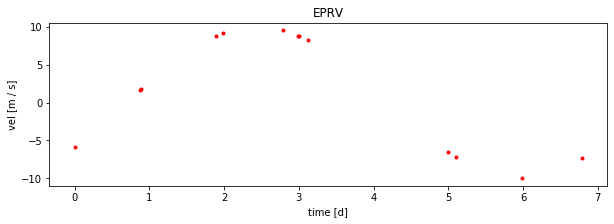

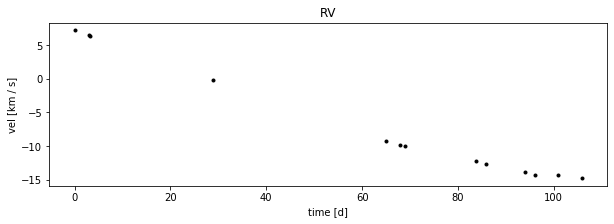

In [10]:
rv = data['data']['rvs'].to(u.km/u.s)
bc  = target.radial_velocity_correction(obstime=times,location=loc).to(u.km/u.s)
eprv = rv - bc

plt.figure(figsize=(10,3))
plt.title('EPRV')
v_unit = u.m/u.s
plt.plot((times - min(times)).to(u.day).value % period.to(u.day).value,eprv.to(v_unit).value,'.r')
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.show()

plt.figure(figsize=(10,3))
plt.title('RV')
v_unit = u.km/u.s
plt.plot((times - min(times)).to(u.day).value,rv.to(v_unit).value,'.k')
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.show()

<h2>Loss Function</h2>
Define the loss function from the jabble.loss module. If the errorbars are too bad, use the L2Loss function.

In [11]:
loss = jabble.loss.L2Loss()

<h2>Create the StellarModel</h2>
Here we are creating a two part CompositeModel.

In [12]:
vel_padding = 50 * u.km/u.s
x_grid        = jabble.model.create_x_grid(wob_data.xs,vel_padding,resolution)
stellar_model = jabble.model.CompositeModel([jabble.model.ShiftingModel(init_shifts),jabble.model.JaxLinear(x_grid)])
stellar_model[1].fit()

<h2>Now Initialize the Tellurics Model</h2>
And add it the stellar model

In [13]:
times = at.Time([obs_times[i] + exp_times[i]/2 for i in range(len(obs_times))])
telescope_frame = coord.AltAz(obstime=times,location=loc)
secz = np.array(target.transform_to(telescope_frame).secz)

In [14]:
tellurics_model = jabble.model.CompositeModel([jabble.model.JaxLinear(x_grid),jabble.model.StretchingModel(p=secz)])
tellurics_model.fix()

In [15]:
total_model = tellurics_model + stellar_model

Display shows the container models and their submodels along with which ones are being fit atm. And how many parameters they take.

In [16]:
total_model.display()

-AdditiveModel---------------------------------3312
  -CompositeModel---------------------------------0
    -JaxLinear------------------------------------0
    -StretchingModel------------------------------0
  -CompositeModel------------------------------3312
    -ShiftingModel--------------------------------0
    -JaxLinear---------------------------------3312


<h2>Fitting Time</h2>
Now it's time to fit the model to the data using our loss function. And setting some maxiter to stop early to prevent any overfitting.

In [17]:
maxiter = 8
res1 = total_model.optimize(loss,wob_data,maxiter)

[ Value: +1.63e+05 Grad: +1.28e+01 ]
[ Value: +1.60e+05 Grad: +1.27e+01 ]
[ Value: +1.49e+05 Grad: +1.23e+01 ]
[ Value: +1.10e+05 Grad: +1.04e+01 ]
[ Value: +1.21e+04 Grad: +4.59e-02 ]
[ Value: +1.17e+04 Grad: +1.03e-02 ]
[ Value: +1.14e+04 Grad: -1.18e-02 ]
[ Value: +1.14e+04 Grad: +8.29e-03 ]
[ Value: +1.14e+04 Grad: -1.81e-03 ]
[ Value: +1.14e+04 Grad: +1.04e-03 ]
[ Value: +1.14e+04 Grad: +3.00e-03 ]
[ Value: +1.14e+04 Grad: -5.54e-04 ]


In [18]:
print(res1)

      fun: array(11352.99609375)
 hess_inv: <3312x3312 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., ..., 0., 0., 0.])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 12
      nit: 8
     njev: 12
   status: 1
  success: False
        x: array([0., 0., 0., ..., 0., 0., 0.])


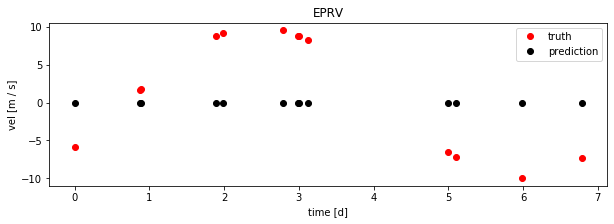

In [19]:
fit_vel = jabble.dataset.velocityfromshift(total_model[1][0].p)
plt.figure(figsize=(10,3))
plt.title('EPRV')
v_unit = u.m/u.s

plt.plot((times - min(times)).to(u.day).value % period.value,(rv-bc).to(v_unit).value,'or',label='truth')
plt.plot((times - min(times)).to(u.day).value % period.value,(fit_vel-bc).to(v_unit).value,'ok',label='prediction')

plt.legend()
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.show()

In [20]:
maxiter = 12
total_model.fix(0,1)
res2 = total_model.optimize(loss,wob_data,maxiter)

[ Value: +1.14e+04 Grad: -5.54e-04 ]
[ Value: +1.14e+04 Grad: +6.92e-03 ]
[ Value: +1.14e+04 Grad: +1.01e-03 ]
[ Value: +1.14e+04 Grad: +7.01e-04 ]
[ Value: +1.14e+04 Grad: +1.20e-03 ]
[ Value: +1.14e+04 Grad: -7.41e-03 ]
[ Value: +1.14e+04 Grad: -9.35e-04 ]
[ Value: +1.13e+04 Grad: +1.48e-03 ]
[ Value: +1.13e+04 Grad: +1.32e-03 ]
[ Value: +1.13e+04 Grad: -1.35e-03 ]
[ Value: +1.13e+04 Grad: +1.93e-03 ]
[ Value: +1.13e+04 Grad: +1.89e-04 ]
[ Value: +1.13e+04 Grad: +5.71e-05 ]
[ Value: +1.13e+04 Grad: +1.12e-04 ]
[ Value: +1.13e+04 Grad: -3.89e-04 ]


In [21]:
print(res2)

      fun: array(11349.6875)
 hess_inv: <3312x3312 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., ..., 0., 0., 0.])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 15
      nit: 12
     njev: 15
   status: 1
  success: False
        x: array([0., 0., 0., ..., 0., 0., 0.])


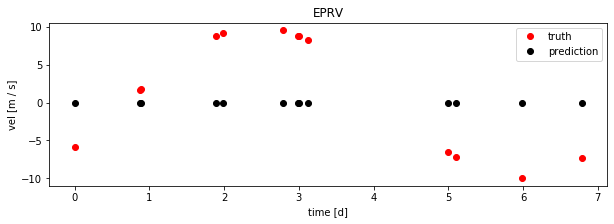

In [22]:
fit_vel = jabble.dataset.velocityfromshift(total_model[1][0].p)
plt.figure(figsize=(10,3))
plt.title('EPRV')
v_unit = u.m/u.s

plt.plot((times - min(times)).to(u.day).value % period.value,(rv-bc).to(v_unit).value,'or',label='truth')
plt.plot((times - min(times)).to(u.day).value % period.value,(fit_vel-bc).to(v_unit).value,'ok',label='prediction')

plt.legend()
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.show()

In [23]:
import scipy.ndimage
def normalize(y,yerr,sigma):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y/y_low, yerr/y

/Users/matthewdaunt/Documents/pythons/wobble_toys/repos/WobbleSim/simulacra/dataset.py:181: RuntimeWarning: invalid value encountered in log
  y, yerr = np.log(y), yerr/y


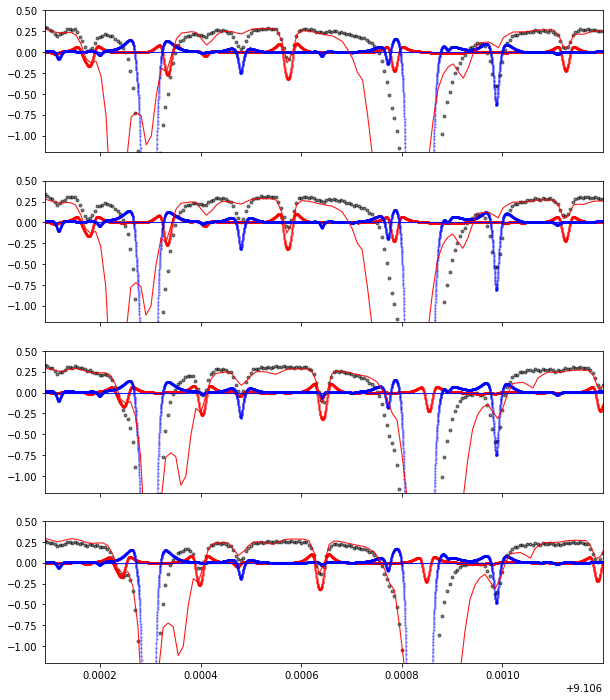

In [24]:
sigma = 80
xpmin = np.log(9010)
xpmax = np.log(9020)
plt_unit = u.Angstrom
plt_epoch = 4
fig, axes = plt.subplots(plt_epoch,figsize=(10,3 *plt_epoch),sharex=True,sharey=True)
for i in range(plt_epoch):
    data.plot_star(axes[i],i,xy='xy',units=plt_unit,normalize=normalize,nargs=[sigma])
    data.plot_tellurics(axes[i],i,xy='xy',units=plt_unit,normalize=normalize,nargs=[sigma])
    axes[i].errorbar(wob_data.xs[i,:],wob_data.ys[i,:],wob_data.yerr[i,:],fmt='.k',elinewidth=0.7,zorder=1,alpha=0.5,ms=6)
    axes[i].plot(total_model[1][1].xs-total_model[1][0].p[i],total_model[1][1].p,'r',linestyle='solid',linewidth=1.1,zorder=2,alpha=0.9,ms=6)
    axes[i].plot(total_model[0][0].xs,total_model[0][0].p*total_model[0][1].p[i],'b',linestyle='solid',linewidth=1.1,zorder=2,alpha=0.9,ms=6)
    
    axes[i].set_xlim(xpmin,xpmax)
    axes[i].set_ylim(-1.2,0.5)
plt.show()

<h2>Grid Search Velocity Shifts</h2>
Now that we have moderately fit the model to the data. We can try a preliminary velocity grid search. First define the velocities to be searched at each epoch. Simply take the init velocities then outer add using some velocity kernel. Here we decide the step size to be: <br>
$$\Delta v = \frac{c}{R}$$

In [25]:
print(total_model.parameters_per_model)

[   0. 3312.]


In [26]:
vel_width = 10 * u.km/u.s
vel_step = const.c/resolution/10.
velocity_kern = np.arange(-vel_width.to(u.km/u.s).value,vel_width.to(u.km/u.s).value,vel_step.to(u.km/u.s).value)*u.km/u.s
velocity_grid = np.add.outer(bc,velocity_kern)

shift_grid = jabble.dataset.shifts(velocity_grid)
loss_array = total_model[1][0].grid_search(shift_grid,loss,total_model,wob_data)

-AdditiveModel-----------------------------------13
  -CompositeModel---------------------------------0
    -JaxLinear------------------------------------0
    -StretchingModel------------------------------0
  -CompositeModel--------------------------------13
    -ShiftingModel-------------------------------13
    -JaxLinear------------------------------------0


In [27]:
total_model.display()

-AdditiveModel-----------------------------------13
  -CompositeModel---------------------------------0
    -JaxLinear------------------------------------0
    -StretchingModel------------------------------0
  -CompositeModel--------------------------------13
    -ShiftingModel-------------------------------13
    -JaxLinear------------------------------------0


In [28]:
print(vel_step)

299.792458 m / s


The grid search returns a loss array of the same size as the velocity grid. Now we take the lowest loss of each epoch on these grids along with it's two neighbors, and create a parabola. The minimum of that parabola is used as the new velocity shift.

In [29]:
x_min, x_vals, y_vals, polynomials = jabble.dataset.get_parabolic_min(loss_array,shift_grid,return_all=True)
stellar_model[0].p = x_min

epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 40
epch 3: min 35
epch 4: min 42
epch 5: min 0
minimum likely out of range
epch 6: min 23
epch 7: min 0
minimum likely out of range
epch 8: min 25
epch 9: min 40
epch 10: min 33
epch 11: min 39
epch 12: min 26


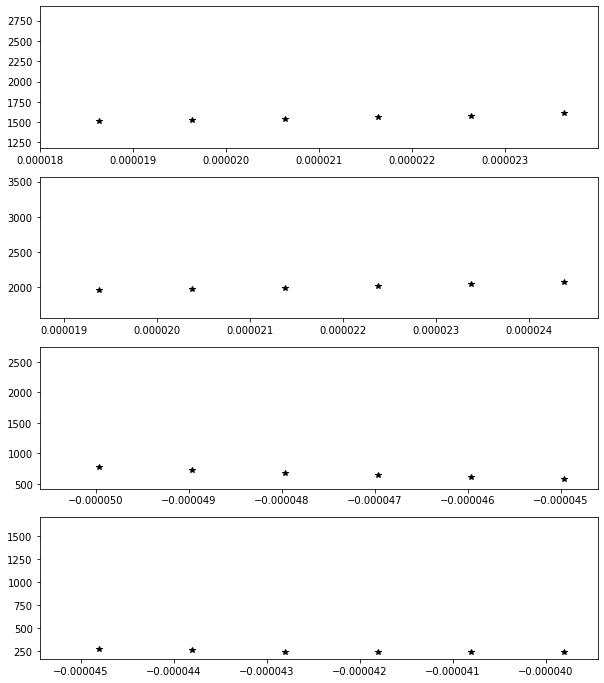

In [30]:
plt_epoch = 4
fig, axes = plt.subplots(plt_epoch,figsize=(10,3 *plt_epoch))
for i in range(plt_epoch):
    axes[i].set_xlim(init_shifts[i]-3*jabble.dataset.shifts(vel_step),init_shifts[i]+3*jabble.dataset.shifts(vel_step))
    axes[i].plot(shift_grid[i,:],loss_array[i,:],'*k')
plt.show()

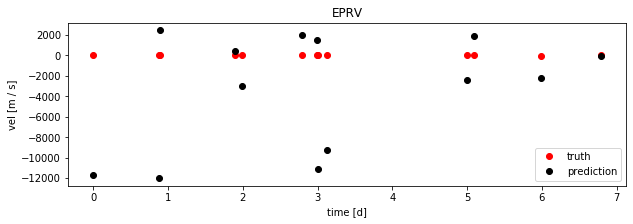

In [31]:
min_vel = jabble.dataset.velocityfromshift(x_min)
plt.figure(figsize=(10,3))
plt.title('EPRV')
v_unit = u.m/u.s

plt.plot((times - min(times)).to(u.day).value % period.value,(rv-bc).to(v_unit).value,'or',label='truth')
plt.plot((times - min(times)).to(u.day).value % period.value,(min_vel-bc).to(v_unit).value,'ok',label='prediction')

plt.legend()
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.show()

<h2>Second Round of Fitting</h2>
Now once we have a better velocity estimate, we can fit both the jaxlinear model and the shifting model simultaneously!

In [32]:
total_model.fit(1,0)
total_model.fit(1,1)
maxiter = 32
total_model[1][0].p = init_shifts
res3 = total_model.optimize(loss,wob_data,maxiter)

[ Value: +1.14e+04 Grad: -4.51e+03 ]
[ Value: +1.65e+05 Grad: -3.31e+03 ]
[ Value: +1.67e+05 Grad: -1.06e+04 ]
[ Value: +1.70e+05 Grad: -9.69e+03 ]
[ Value: +2.05e+05 Grad: -1.24e+04 ]
[ Value: +1.99e+05 Grad: -6.05e+03 ]
[ Value: +1.21e+05 Grad: -3.78e+03 ]
[ Value: +4.36e+04 Grad: -1.51e+04 ]
[ Value: +1.68e+04 Grad: -2.98e+04 ]
[ Value: +1.02e+04 Grad: +2.90e+04 ]
[ Value: +1.01e+04 Grad: +9.50e+03 ]
[ Value: +1.01e+04 Grad: -4.08e+03 ]
[ Value: +1.00e+04 Grad: +1.12e+03 ]
[ Value: +1.01e+04 Grad: -6.81e+02 ]
[ Value: +1.00e+04 Grad: +1.12e+03 ]
[ Value: +1.00e+04 Grad: +1.12e+03 ]
[ Value: +1.00e+04 Grad: +1.12e+03 ]
[ Value: +1.00e+04 Grad: +1.12e+03 ]
[ Value: +1.00e+04 Grad: +1.12e+03 ]
[ Value: +1.00e+04 Grad: +1.12e+03 ]
[ Value: +1.00e+04 Grad: +1.12e+03 ]
[ Value: +1.00e+04 Grad: +1.12e+03 ]
[ Value: +1.00e+04 Grad: +1.12e+03 ]
[ Value: +1.00e+04 Grad: +1.12e+03 ]
[ Value: +1.00e+04 Grad: +1.12e+03 ]
[ Value: +1.00e+04 Grad: +1.12e+03 ]
[ Value: +1.00e+04 Grad: +1.12e+03 ]
[

These finals velocities will be compared with the known values from Simulacra.

In [33]:
final_vels = jabble.dataset.velocityfromshift(stellar_model[0].p)

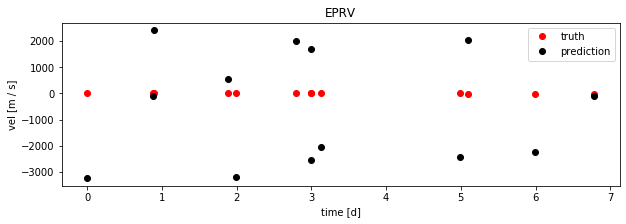

In [34]:
plt.figure(figsize=(10,3))
plt.title('EPRV')
v_unit = u.m/u.s

plt.plot((times - min(times)).to(u.day).value % period.value,(rv-bc).to(v_unit).value,'or',label='truth')
plt.plot((times - min(times)).to(u.day).value % period.value,(final_vels-bc).to(v_unit).value,'ok',label='prediction')

plt.legend()
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.show()


# plt.ylim(-1,1)